As Heng mentioned here, his latest experiments uses Classification + Segmentation pipeline, shown in the figure below:
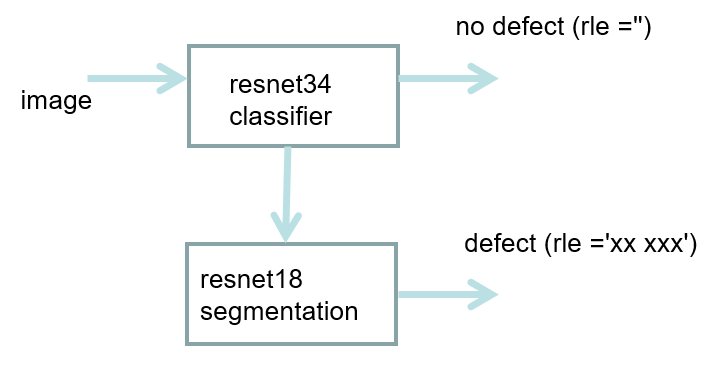

This kernel helps you to train restnet34 model for steel dataset . Its giving 82% accuracy on validatation set . If you need to improve accuracy try your tweaks in the code . After training for inference you can refer this notebook : https://www.kaggle.com/bibek777/heng-s-model-inference-kernel. Happy Coding ! **Please UPVOTE if you find this kernel useful .**

In [ ]:
import pdb
import os
import cv2
import torch
import pandas as pd
import numpy as np
import time
from torch.autograd import Variable
from tqdm import tqdm
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Dataset
from albumentations import (Resize, Normalize, Compose)
from albumentations.pytorch import ToTensor
import matplotlib.pyplot as plt
import torchvision
from torch.nn.modules.loss import NLLLoss
import torch.utils.data as data
import torchvision.models as models
import torch.nn as nn
from torch import optim
from torch.optim import lr_scheduler
from torch.nn import functional as F

torch.backends.cudnn.enabled = False

### Building the datapipeline

In [ ]:
df = pd.read_csv("/kaggle/input/severstal-steel-defect-detection/train.csv")
df.head()

In [ ]:
train_defect = df[df["EncodedPixels"].notnull()]

master_df = pd.DataFrame()
master_df["Image_Class"]=train_defect["ImageId_ClassId"]

def image_id(row):
    return row['Image_Class'].strip().split("_")[0]

def class_id(row):
    return row["Image_Class"].strip().split("_")[1]

master_df["ImageId"] = master_df.apply(image_id,axis=1)
master_df["ClassId"] = master_df.apply(class_id,axis=1)
master_df = master_df.drop(["Image_Class"],axis=1)
master_df = master_df.reset_index()
master_df = master_df.drop(["index"] , axis=1)
master_df.head()

In [ ]:
# Split into train and test
msk = np.random.rand(len(master_df)) < 0.8
train_df = master_df[msk]
train_df = train_df.reset_index(drop=True)
val_df = master_df[~msk]
val_df = val_df.reset_index(drop=True)
val_df.head()

In [ ]:
class Dataset_Classifier(Dataset):
    def __init__(self, root, df):
        mean = (0.485, 0.456, 0.406)
        std = (0.229, 0.224, 0.225)
        self.root = root
        self.df = df
        self.num_samples = len(self.df)
        self.transform = Compose(
            [
            #Resize(224,224),
             Normalize(mean = mean , std = std, p=1),
            ToTensor(),
            ])
        
    def __getitem__(self,idx):
        fname = self.df["ImageId"][idx]
        path = os.path.join(self.root, fname)
        image = cv2.imread(path)
        images = self.transform(image=image)["image"]
        label = self.df["ClassId"][idx]
        return images, torch.from_numpy(np.array([int(label)-1],dtype=np.float32))
    
    def __len__(self):
        return self.num_samples

In [ ]:
# Creating Traindataset
train_data_folder = "/kaggle/input/severstal-steel-defect-detection/train_images/"
train_dataset = Dataset_Classifier(train_data_folder,train_df)

# Creating Validation Dataset
val_dataset = Dataset_Classifier(train_data_folder,val_df)

In [ ]:
# Creating Train DataLoader
train_dataloader = DataLoader(train_dataset,shuffle = False,batch_size = 128)

# Creating Test DataLoader
val_dataloader = DataLoader(val_dataset,shuffle = False,batch_size = 32)

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    

# Visualize our dataloader works fine
example = next(iter(train_dataloader))

out = torchvision.utils.make_grid(example[0])
print(example[1])
imshow(out)

In [ ]:
BatchNorm2d = nn.BatchNorm2d

class BasicBlock(nn.Module):
    def __init__(self, in_channel, channel, out_channel, stride=1, is_shortcut=False):
        super(BasicBlock, self).__init__()
        self.is_shortcut = is_shortcut

        self.conv_bn1 = ConvBn2d(in_channel,    channel, kernel_size=3, padding=1, stride=stride)
        self.conv_bn2 = ConvBn2d(   channel,out_channel, kernel_size=3, padding=1, stride=1)

        if is_shortcut:
            self.shortcut = ConvBn2d(in_channel, out_channel, kernel_size=1, padding=0, stride=stride)


    def forward(self, x):
        z = F.relu(self.conv_bn1(x),inplace=True)
        z = self.conv_bn2(z)

        if self.is_shortcut:
            x = self.shortcut(x)

        z += x
        z = F.relu(z,inplace=True)
        return z


class ConvBn2d(nn.Module):

    def __init__(self, in_channel, out_channel, kernel_size=3, padding=1, stride=1):
        super(ConvBn2d, self).__init__()
        self.conv = nn.Conv2d(in_channel, out_channel, kernel_size=kernel_size, padding=padding, stride=stride, bias=False)
        self.bn   = nn.BatchNorm2d(out_channel, eps=1e-5)

    def forward(self,x):
        x = self.conv(x)
        x = self.bn(x)
        return x


class ResNet34(nn.Module):

    def __init__(self, num_class=1000 ):
        super(ResNet34, self).__init__()


        self.block0  = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, padding=3, stride=2, bias=False),
            BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.block1  = nn.Sequential(
             nn.MaxPool2d(kernel_size=3, padding=1, stride=2),
             BasicBlock( 64, 64, 64, stride=1, is_shortcut=False,),
          * [BasicBlock( 64, 64, 64, stride=1, is_shortcut=False,) for i in range(1,3)],
        )
        self.block2  = nn.Sequential(
             BasicBlock( 64,128,128, stride=2, is_shortcut=True, ),
          * [BasicBlock(128,128,128, stride=1, is_shortcut=False,) for i in range(1,4)],
        )
        self.block3  = nn.Sequential(
             BasicBlock(128,256,256, stride=2, is_shortcut=True, ),
          * [BasicBlock(256,256,256, stride=1, is_shortcut=False,) for i in range(1,6)],
        )
        self.block4 = nn.Sequential(
             BasicBlock(256,512,512, stride=2, is_shortcut=True, ),
          * [BasicBlock(512,512,512, stride=1, is_shortcut=False,) for i in range(1,3)],
        )
        self.logit = nn.Linear(512,num_class)



    def forward(self, x):
        batch_size = len(x)

        x = self.block0(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = F.adaptive_avg_pool2d(x,1).reshape(batch_size,-1)
        logit = self.logit(x)
        return logit

Now we created the Resnet34 Block , now we define the blocks according to the way we want 

In [ ]:
class Resnet34_classification(nn.Module):
    def __init__(self,num_class=4):
        # Abstracting the Resnet 34 Class 
        super(Resnet34_classification, self).__init__()
        e = ResNet34()
        # Defining the blocks we want from Resnet
        self.block = nn.ModuleList([
            e.block0,
            e.block1,
            e.block2,
            e.block3,
            e.block4,
        ])
        # After defining the blocks we are dropping the parent Resnet
        e = None  #dropped
        
        # Extracting the features
        self.feature_1 = nn.Conv2d(512,32, kernel_size=1) #dummy conv for dim reduction
        # Getting the logits
        self.feature_2 = nn.Linear(32,num_class)
        self.logit = nn.LogSoftmax(dim=1)

    def forward(self, x):
        batch_size,C,H,W = x.shape

        for i in range( len(self.block)):
            x = self.block[i](x)
            #print(i, x.shape)

        x = F.dropout(x,0.5,training=self.training)
        x = F.adaptive_avg_pool2d(x, 1)
        x = self.feature_1(x)
        x = x.view(-1,32)
        x = self.feature_2(x)
        logit = self.logit(x)
        return logit

In [ ]:
# Use GPU
use_gpu = torch.cuda.is_available()

# Declare the Network
model = Resnet34_classification()

# model = models.resnet18(pretrained=True)
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, 4)

if use_gpu:
    model = model.cuda()

# Declare Loss Function
criterion = nn.CrossEntropyLoss()

# Declare Optimizer 
optimizer = optim.Adam(model.parameters(),  lr=0.0001)

# Scheduler 
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
# Training Function 
def train(model,criterion, optimizer, scheduler, dataloader, use_gpu, num_epochs=20):
    print("Training Initiated")
    since = time.time()
    steps = 0
    model.train(True)
    #scheduler.step()
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        
        running_loss = 0.0
        
        for data in dataloader:
            
            steps += 1
            inputs, labels = data
            if use_gpu:
                
                inputs = inputs.cuda()
                labels = labels.cuda()
                
            optimizer.zero_grad()
            #m = nn.LogSoftmax(dim=1)
            outputs = model.forward(inputs)
#             outputs = m(outputs)
#             outputs = outputs.squeeze()
            labels = labels.squeeze()
#             print(m(outputs).type())
            labels = labels.long()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            if steps % 10 == 0:
                model.eval()
                validation_loss = 0
                accuracy = 0
                for i,(inputs,labels) in enumerate(val_dataloader):
                    optimizer.zero_grad()
                    inputs, labels = inputs.to('cuda') , labels.to('cuda')
                    with torch.no_grad():
                        outputs = model.forward(inputs)
                        labels = labels.squeeze()
                        labels = labels.long()
                        validation_loss = criterion(outputs,labels)
                        ps = torch.exp(outputs).data
                        equality = (labels.data == ps.max(1)[1])
                        accuracy += equality.type_as(torch.FloatTensor()).mean()
                val_loss = validation_loss / len(val_dataloader)
                train_ac = accuracy /len(val_dataloader)
                
                print("Epoch: {}/{}... | ".format(epoch+1, num_epochs),
                      "Loss: {:.4f} | ".format(running_loss/10),
                      "Validation Loss {:.4f} | ".format(val_loss),
                      "Accuracy {:.4f}".format(train_ac))
                
                if train_ac > best_acc :
                    best_acc = train_ac
                    print("------------Saving Best Model-----------")
                    torch.save(model.state_dict(),"models_best.pth")

                running_loss = 0



In [ ]:
try:
    train(model, criterion, optimizer, exp_lr_scheduler, train_dataloader, use_gpu,
                       num_epochs=50)
except:
    torch.save(model.state_dict(),"model_error.pth")

In [ ]:
# saving the model
torch.save(model.state_dict(),"model_last.pth")

In [ ]:
# Loading and check the model
model = Resnet34_classification()
model.load_state_dict(torch.load("model_last.pth"))
model.eval()

After training your classifier , we have to train the segmenatation module . You can find the notebook https://www.kaggle.com/robinreni/pytorch-segnet-deeplabv3-training